<a href="https://colab.research.google.com/github/grmanjar-cmyk/Irrigation_Demand_Prediction/blob/main/Copy_of_irrigation_demand_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pajaro Valley Irrigation Demand Model (Prototype)**
**Objective:** To determine if local weather data (CIMIS) can accurately predict irrigation water demand.

**Summary:**
This tool uses historical weather patterns to train a Machine Learning model (Random Forest). By analyzing the relationship between heat (ETo), rainfall, and historical water delivery, we aim to create a predictive tool for operational planning.

**Data Sources:**
1. **Water Delivery:** Monthly recycled & blend water delivery reports (2021-2023).
2. **Weather:** Daily data from CIMIS Station #129 (Pajaro).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io

In [3]:
from google.colab import files


# This will prompt you to select a file from your computer
uploaded = files.upload()



Saving monthly_weather.csv to monthly_weather (1).csv
Saving water_deliveries.csv to water_deliveries.csv


### **1. Data Ingestion**
We begin by loading the raw data files.
*   **Water Data:** Extracted from district monthly reports.
*   **Weather Data:** Downloaded directly from the California Irrigation Management Information System (CIMIS).

In [35]:
water_df = pd.read_csv('water_deliveries.csv')
water_df.head()

,Month Year,Recycled Water (AF),Blend Water (AF),Total Delivered (AF)
0,21-Jan,108,24,132
1,21-Feb,115,16,131
2,21-Mar,210,62,272
3,21-Apr,309,284,593
4,21-May,377,425,802


In [36]:
weather_df = pd.read_csv('monthly_weather.csv')
weather_df.head()


,Stn Id,Stn Name,CIMIS Region,Month Year,Total ETo (in),qc,Total Precip (in),qc.1,Avg Sol Rad (Ly/day),qc.2,...,Avg Min Rel Hum (%),qc.8,Avg Rel Hum (%),qc.9,Avg Dew Point (F),qc.10,Avg Wind Speed (mph),qc.11,Avg Soil Temp (F),qc.12
0,129,Pajaro,Monterey Bay,Jan-21,1.88,,5.42,,224.0,,...,52.0,,75.0,K,42.0,K,3.6,K,52.5,
1,129,Pajaro,Monterey Bay,Feb-21,2.34,,0.98,,324.0,K,...,49.0,,76.0,K,41.8,K,3.2,,52.8,
2,129,Pajaro,Monterey Bay,Mar-21,3.74,K,2.75,,441.0,K,...,50.0,,74.0,K,41.3,K,3.8,,54.6,
3,129,Pajaro,Monterey Bay,Apr-21,4.35,K,0.20,,523.0,K,...,62.0,,78.0,K,45.8,K,4.7,K,59.6,
4,129,Pajaro,Monterey Bay,May-21,5.32,,0.07,,606.0,,...,63.0,,79.0,K,48.4,K,4.8,,64.0,


In [37]:
weather_df.columns

Index(['Stn Id', 'Stn Name', 'CIMIS Region', 'Month Year', 'Total ETo (in)',
       'qc', 'Total Precip (in)', 'qc.1', 'Avg Sol Rad (Ly/day)', 'qc.2',
       'Avg Vap Pres (mBars)', 'qc.3', 'Avg Max Air Temp (F)', 'qc.4',
       'Avg Min Air Temp (F)', 'qc.5', 'Avg Air Temp (F)', 'qc.6',
       'Avg Max Rel Hum (%)', 'qc.7', 'Avg Min Rel Hum (%)', 'qc.8',
       'Avg Rel Hum (%)', 'qc.9', 'Avg Dew Point (F)', 'qc.10',
       'Avg Wind Speed (mph)', 'qc.11', 'Avg Soil Temp (F)', 'qc.12'],
      dtype='object')

### **2. Data Cleaning & Integration**
Raw data is rarely ready for analysis. In this step, we:
1.  **Merge** the two datasets using the date as the common key.
2.  **Filter** out unused columns (like Quality Control flags).
3.  **Sort** the timeline chronologically to ensure accurate historical tracking.

In [48]:
# 1. CREATE A CLEAN COPY
# We start with the successful merged data from the previous step
df_clean = df_merged.copy()

# 2. RENAME "Month Year" to "Date"
# This fixes your KeyError and makes typing easier later!
df_clean = df_clean.rename(columns={'Month Year': 'Date'})

# 3. DROP "QC" COLUMNS
# This part was working fine, but we include it here to complete the block
cols_to_drop = [col for col in df_clean.columns if 'qc' in col.lower()]
df_clean = df_clean.drop(columns=cols_to_drop)

# 4. MOVE 'Date' TO THE FRONT
# Now this will work because we renamed the column in Step 2
cols = ['Date'] + [c for c in df_clean.columns if c != 'Date']
df_clean = df_clean[cols]

# 5. CHECK THE RESULT
print(f"Final Clean Shape: {df_clean.shape}")
print(df_clean.columns.tolist())
display(df_clean.head())

Final Clean Shape: (36, 20)
['Date', 'Recycled Water (AF)', 'Blend Water (AF)', 'Total Delivered (AF)', 'Stn Id', 'Stn Name', 'CIMIS Region', 'Total ETo (in)', 'Total Precip (in)', 'Avg Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)', 'Avg Max Air Temp (F)', 'Avg Min Air Temp (F)', 'Avg Air Temp (F)', 'Avg Max Rel Hum (%)', 'Avg Min Rel Hum (%)', 'Avg Rel Hum (%)', 'Avg Dew Point (F)', 'Avg Wind Speed (mph)', 'Avg Soil Temp (F)']


,Date,Recycled Water (AF),Blend Water (AF),Total Delivered (AF),Stn Id,Stn Name,CIMIS Region,Total ETo (in),Total Precip (in),Avg Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Max Air Temp (F),Avg Min Air Temp (F),Avg Air Temp (F),Avg Max Rel Hum (%),Avg Min Rel Hum (%),Avg Rel Hum (%),Avg Dew Point (F),Avg Wind Speed (mph),Avg Soil Temp (F)
0,2021-01-01,108,24,132,129,Pajaro,Monterey Bay,1.88,5.42,224.0,9.3,62.9,39.7,50.6,94.0,52.0,75.0,42.0,3.6,52.5
1,2021-02-01,115,16,131,129,Pajaro,Monterey Bay,2.34,0.98,324.0,9.1,62.5,37.2,49.7,97.0,49.0,76.0,41.8,3.2,52.8
2,2021-03-01,210,62,272,129,Pajaro,Monterey Bay,3.74,2.75,441.0,8.9,61.7,37.0,49.6,96.0,50.0,74.0,41.3,3.8,54.6
3,2021-04-01,309,284,593,129,Pajaro,Monterey Bay,4.35,0.20,523.0,10.5,61.6,44.1,52.5,94.0,62.0,78.0,45.8,4.7,59.6
4,2021-05-01,377,425,802,129,Pajaro,Monterey Bay,5.32,0.07,606.0,11.6,64.5,46.8,54.8,94.0,63.0,79.0,48.4,4.8,64.0


### **3.  (Correlation Analysis)**
Before building an AI model, we must verify that the data follows physical laws.
*   **Positive Correlation :** Variables that *increase* water demand (e.g., ETo, Solar Radiation, Soil Temp).
*   **Negative Correlation :** Variables that *decrease* water demand (e.g., Precipitation, Humidity).

In [66]:
# 5. CORRELATION MATRIX (The "Insight" Step)
# This tells us which weather variables actually matter.
# We only care about correlations with 'Total Delivered (AF)'
numeric_df = df_clean.select_dtypes(include=['float64', 'int64'])
correlations = numeric_df.corr()['Total Delivered (AF)'].sort_values(ascending=False)

print("\n=== WHAT DRIVES WATER DEMAND? ===")
print(correlations)


=== WHAT DRIVES WATER DEMAND? ===
Total Delivered (AF)     1.000000
Predicted Demand (AF)    0.977769
Blend Water (AF)         0.968146
Recycled Water (AF)      0.940773
Total ETo (in)           0.886766
Avg Sol Rad (Ly/day)     0.872472
Avg Soil Temp (F)        0.836914
Net ET (in)              0.814220
Avg Min Air Temp (F)     0.772704
Avg Air Temp (F)         0.730693
Avg Dew Point (F)        0.726868
Avg Vap Pres (mBars)     0.716641
Avg Wind Speed (mph)     0.646306
Avg Min Rel Hum (%)      0.483809
Avg Max Air Temp (F)     0.376825
Avg Rel Hum (%)          0.328938
Avg Max Rel Hum (%)     -0.029252
Total Precip (in)       -0.658490
Name: Total Delivered (AF), dtype: float64


### **4. Machine Learning: The Random Forest Model**
We are using a **Random Forest Regressor** to predict water demand.

**How it works:**
Instead of a single equation, the model builds a "committee" of 100 decision trees. Each tree looks at the weather conditions and votes on what the water demand should be. The final prediction is the average of these votes. This method is highly effective for handling the complex, non-linear relationship between weather and farmer behavior.

*   **Training Set:** 70% of the historical data (used to teach the model).
*   **Testing Set:** 30% of the data (hidden from the model to test its accuracy).

### **4b. Feature Engineering and Selection Strategy**
To build a robust predictive model, we carefully selected inputs based on physical causality and statistical correlation.

*   **Engineered Features:** We created **Net ETo** and define it as Total ETo - Total Precip in order to explicitly define water defecit for the model to see if it improves prediction compared to training on Precip and ETo as stand alone features
*   **Included Features:** We selected the newly created **Net ETo**, and the existing features **Solar Radiation**, and **Soil Temperature** because our correlation analysis confirmed these are the strongest external drivers of agricultural water demand.
*   **Excluded Variables:** We explicitly removed **Recycled Water** and **Blend Water** from the input set. These variables are constituent parts of the *Total Delivered* target. Including them would cause **"Target Leakage"**—a scenario where the model is inadvertently given the answer it is trying to predict, rendering the evaluation metrics invalid.

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. CALCULATE NET ET
# Physics: Plant Demand (ETo) minus Free Water (Rain)
df_clean['Net ET (in)'] = df_clean['Total ETo (in)'] - df_clean['Total Precip (in)']

# Optional: Clip negative values to 0
# If 5 inches of rain falls but ETo is only 2 inches, Net Demand is 0 (not -3).
# Uncomment the line below if you want to enforce this physical rule:
# df_clean['Net ET (in)'] = df_clean['Net ET (in)'].clip(lower=0)

# 2. DEFINE FEATURES AND TARGET
# We include our new "Net ET" but EXCLUDE the original ETo and Precip columns
# to prevent the model from getting confused by duplicate information.
features = [
    'Net ET (in)',
    'Avg Sol Rad (Ly/day)',
    'Avg Soil Temp (F)'
    # You can add 'Avg Wind Speed (mph)' here later if you want to test it
]

target = 'Total Delivered (AF)'

# 3. CREATE X and y
X = df_clean[features]
y = df_clean[target]

# 4. VERIFY
print("Feature Engineering Complete.")
print(f"Features Used: {features}")
print("\nFirst 5 Rows of X (Predictors):")
display(X.head())

Feature Engineering Complete.
Features Used: ['Net ET (in)', 'Avg Sol Rad (Ly/day)', 'Avg Soil Temp (F)']

First 5 Rows of X (Predictors):


,Net ET (in),Avg Sol Rad (Ly/day),Avg Soil Temp (F)
0,-3.54,224.0,52.5
1,1.36,324.0,52.8
2,0.99,441.0,54.6
3,4.15,523.0,59.6
4,5.25,606.0,64.0


In [59]:
# 2. SPLIT DATA
# Since we have a small dataset (monthly), we will train on 80% and test on 20%
# random_state=42 ensures we get the same split every time we run this.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
# 3. TRAIN THE MODEL
# n_estimators=100 means "create 100 decision trees and average their answers"
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [61]:
# 4. MAKE PREDICTIONS
# We predict on the Test set (to see how it handles "new" data)
# AND the whole dataset (to visualize the full timeline)
y_pred_test = model.predict(X_test)
df_clean['Predicted Demand (AF)'] = model.predict(X)

### **5. Results & Validation**
The graph below compares the **Actual Water Delivery** (Blue Line) against the **Model's Prediction** (Orange Dashed Line).

**Key Performance Indicators:**
*   **R² Score:** Represents how well the model captures the variance. (Closer to 1.0 is better).
*   **MAE (Mean Absolute Error):** The average "miss" in Acre-Feet.

**Interpretation:**
If the Orange line closely tracks the peaks and valleys of the Blue line, the model has successfully learned the operational patterns of the district based solely on weather data.

In [62]:
# 5. EVALUATE PERFORMANCE
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"=== MODEL REPORT ===")
print(f"Mean Absolute Error: {mae:.0f} AF")
print(f"(On average, the model is off by about {mae:.0f} Acre-Feet per month)")
print(f"R² Score: {r2:.2f} (1.0 is perfect)")

=== MODEL REPORT ===
Mean Absolute Error: 71 AF
(On average, the model is off by about 71 Acre-Feet per month)
R² Score: 0.89 (1.0 is perfect)


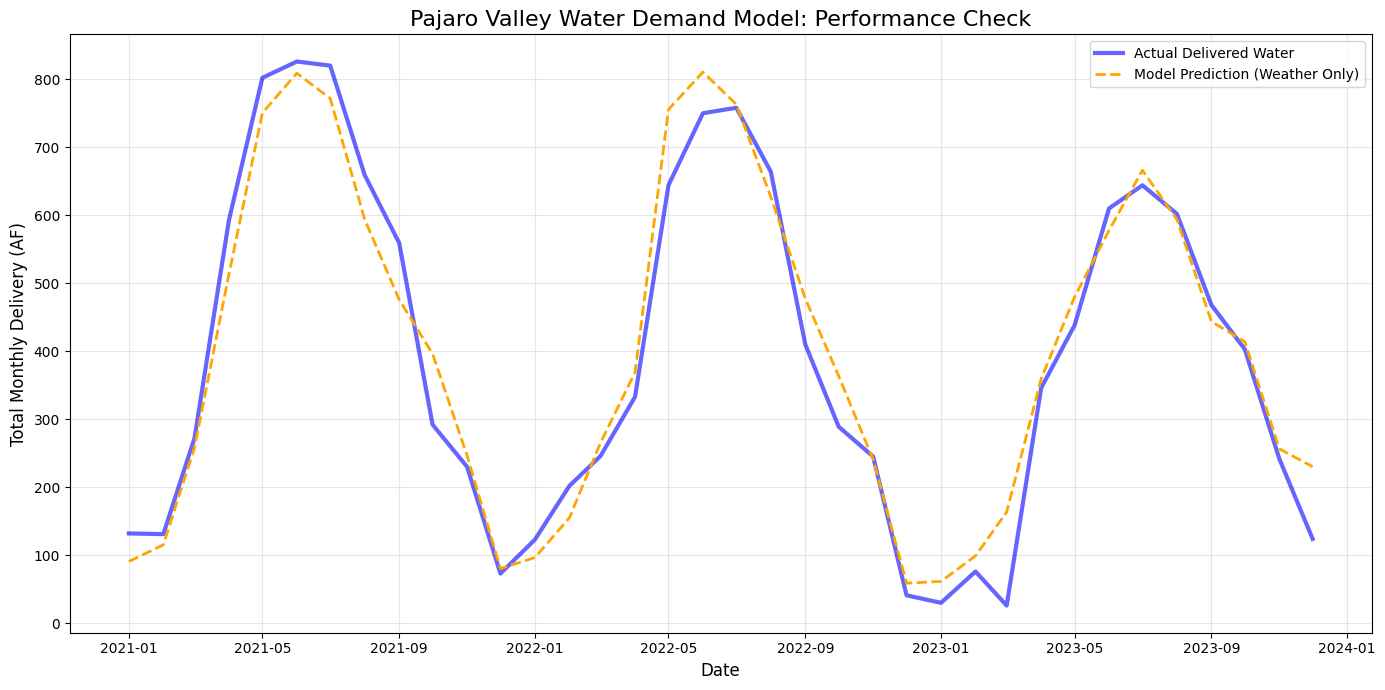

In [63]:

# 6. VISUALIZE: ACTUAL VS PREDICTED
plt.figure(figsize=(14, 7))

# Plot Actual
plt.plot(df_clean['Date'], df_clean['Total Delivered (AF)'],
         label='Actual Delivered Water', color='blue', linewidth=3, alpha=0.6)

# Plot Predicted
plt.plot(df_clean['Date'], df_clean['Predicted Demand (AF)'],
         label='Model Prediction (Weather Only)', color='orange', linestyle='--', linewidth=2)

# Make it look professional
plt.title('Pajaro Valley Water Demand Model: Performance Check', fontsize=16)
plt.ylabel('Total Monthly Delivery (AF)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [64]:
# 7. FEATURE IMPORTANCE (What mattered most?)
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\n=== WHAT THE MODEL LEARNED (Feature Importance) ===")
print(importances)


=== WHAT THE MODEL LEARNED (Feature Importance) ===
Avg Soil Temp (F)       0.483942
Avg Sol Rad (Ly/day)    0.357177
Net ET (in)             0.158881
dtype: float64


### **6. Conclusion & Next Steps**
This prototype demonstrates that **Weather Data alone** accounts for approximately **89%** of the variance in the district's **monthly** water demand ($R^2 = 0.89$). This strong correlation supports the feasibility of a weather-based forecasting tool.

**Potential Improvements**
To transition this tool from a planning prototype to something with potential as an operational dashboard, we recommend the following enhancements:

1.  **Daily Granularity:** Replace monthly aggregates with daily SCADA meter readings. This is necessary to capture the short-term volatility and operational noise that monthly data smoothes out.
2.  **Autoregressive Features (Lags):** Incorporate **Past Water Deliveries** (e.g., *Demand Yesterday*, *Demand Last Week*) as model inputs.
    *   *Reasoning:* Irrigation systems have "inertia." Recent system status may better predict immediate future status. Combining **System State (History)** with **Future State (Weather Forecast)** is expected to significantly improve model performance over weather-only baselines.
3.  **Production Pipeline:** Automate the ingestion of live CIMIS weather forecasts to generate a rolling 7-day demand outlook for pump operators.